In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
plt.rcParams['image.cmap'] = 'bone'

from meld.recon import UnrolledNetwork
from meld.util import getAbs, getPhase
from meld.model import pytorch_proximal

import h5py
import mri
import model
import dataloader
import lib_complex as cp
import os

In [2]:
# Setup device
device_no = 1
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32

# Data Loading

In [3]:
datapath = '/tmp/kellman/3d_dataset_imgs_50.h5'
mapspath = '/tmp/kellman/3d_dataset_maps_50.h5'
maskpath = '/tmp/kellman/3d_dataset_masks_50.h5'

dataset = dataloader.dataloader(datapath, noise_std = 3e-2, mask_path = maskpath, maps_path = mapspath, device=device, maskshift=False, numcoils = 8)

full_len = len(dataset)
train_len = int(0.960*full_len)
test_len = full_len - train_len
print(train_len, test_len)
training_dataset, testing_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

Nbatch_size = 4 # effective batch size (can only do one at a time...)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=Nbatch_size, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=Nbatch_size, shuffle=True)

92 4


## Setting up model and training

In [4]:
metadata = {'num_unrolls': 5, 'lamb': 1, 'alpha': 1e-2}

In [5]:
torch.manual_seed(0)
mri_network = model.model(metadata, device=device, debug=False, num_layers=5, num_filters=32, ndim=3)
mri_network_manager = UnrolledNetwork(mri_network.network, None, 11000, device=device, setupFlag=False)
mri_network_manager.meldFlag = True
mri_network_manager.cpList = [-1]

Nepochs = 20
test_freq = 15
learning_rate = 1e-5
optim = torch.optim.Adam(mri_network.network.parameters(),lr=learning_rate)
training_losses = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))
testing_losses = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))

In [ ]:
for ee in range(Nepochs):
    for tt, x_batch in enumerate(training_loader):
        imgs_0, maps_0, meas_0, mask_0 = x_batch
        idx = ee*int(train_len/Nbatch_size) + tt
        optim.zero_grad()
        for bb in range(Nbatch_size):
            
            adj_0 = mri_network.initialize(imgs_0[bb:bb+1,...].to(device),
                                           maps_0[bb:bb+1,...].to(device), 
                                           meas_0[bb:bb+1,...].to(device),
                                           mask_0[bb:bb+1,...].to(device), device)
        
            xN, loss_tmp, _, _ = mri_network_manager.forward(adj_0, imgs_0.to(device), interFlag=False)
            training_losses[idx] += loss_tmp.detach().cpu().numpy()/Nbatch_size

        optim.step()
        

        if np.mod(idx,test_freq)==0:
            for _, x_batch in enumerate(testing_loader):
                imgs_0, maps_0, meas_0, mask_0 = x_batch
                for bb in range(Nbatch_size):
            
                    adj_0 = mri_network.initialize(imgs_0[bb:bb+1,...].to(device),
                                                   maps_0[bb:bb+1,...].to(device), 
                                                   meas_0[bb:bb+1,...].to(device),
                                                   mask_0[bb:bb+1,...].to(device), device)
                    xN, loss_tmp = mri_network_manager.loss_eval(adj_0, imgs_0.to(device))
                    testing_losses[idx] += loss_tmp.detach().cpu().numpy()/Nbatch_size

        print('Epoch: {0:d} | Iter: {1:d} | Loss: {2:f}'.format(ee, tt, training_losses[idx]), end="\r")

/home/kellman/Workspace/PYTHON/experiment_mri/dataloader.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  mask_0 = torch.tensor(masks.astype(self.np_dtype))


23.0
(460,) (460,)


/home/kellman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


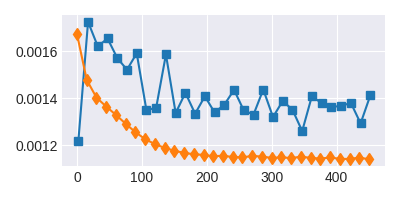

/home/kellman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [12]:
plt.style.use('seaborn-dark')
print(train_len/Nbatch_size)
learning_iter = Nepochs * (train_len/Nbatch_size)
x = np.linspace(0,learning_iter-1,learning_iter)
Nskip = 15

tmp = np.convolve(training_losses, np.ones((Nskip,))/Nskip, mode='same')
print(training_losses.shape, tmp.shape)

plt.figure(figsize=(4,2))
plt.plot(x[2::Nskip],tmp[2::Nskip],'C0s-') #,label='standard learning')
plt.plot(x[::15],testing_losses[::15],'C1d-') #,label='memory-efficient learning')
# plt.legend()
plt.grid('on')
plt.tight_layout()
# plt.savefig('./figures/3d_testing_loss_cmp.pdf',dpi=100)

In [13]:
# !mkdir ./models
torch.save(mri_network.network.state_dict(), './models/version4_5unrolls_5layers_32ch')

In [14]:
cg_recon = []
meld_recon = []
adj_recon = []
truth = []
for _, x_batch in enumerate(testing_loader):
    imgs_0, maps_0, meas_0, mask_0 = x_batch
    adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    recon_0, loss_tmp = mri_network_manager.loss_eval(adj_0, imgs_0.to(device))
    cg_0 = mri_network.mri_model(torch.zeros_like(adj_0), max_iter = 40, eps=1e-12, device = device).detach().cpu()
    
    cg_recon.append(getAbs(cg_0).numpy())
    meld_recon.append(getAbs(recon_0.detach().cpu()).numpy())
    adj_recon.append(getAbs(adj_0.detach().cpu()).numpy())
    truth.append(getAbs(imgs_0.cpu()).numpy())

/home/kellman/Workspace/PYTHON/experiment_mri/dataloader.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  mask_0 = torch.tensor(masks.astype(self.np_dtype))


In [15]:
print(np.array(cg_recon).reshape((Nbatch_size,50,256,320)).shape) #.shape)
cg_recon2 = np.array(cg_recon).reshape((Nbatch_size,50,256,320))
meld_recon2 = np.array(meld_recon).reshape((Nbatch_size,50,256,320))
adj_recon2 = np.array(adj_recon).reshape((Nbatch_size,50,256,320))
truth2 = np.array(truth).reshape((Nbatch_size,50,256,320))

(4, 50, 256, 320)


## Visualization comparison

<IPython.core.display.Javascript object>


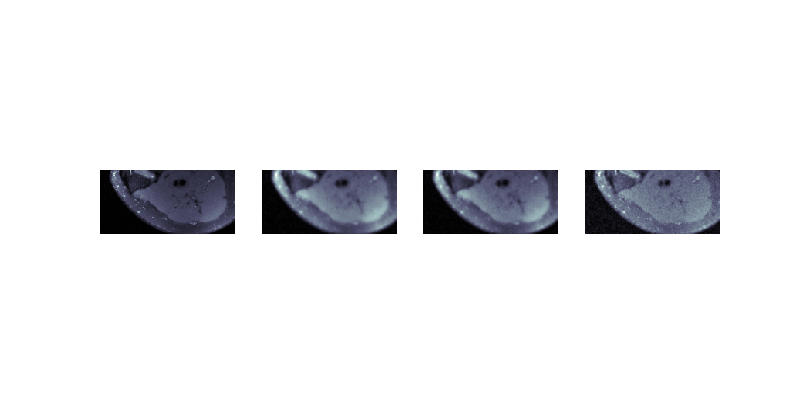

(-0.5, 255.5, 319.5, -0.5)

In [16]:
view = lambda x : x.transpose()

plt.rcParams['image.cmap'] = 'bone'

idx = 3
slice_idx = 35
vmax = np.max(truth2[idx, slice_idx, ...])

fig, ax = plt.subplots(1, 4, figsize=(8,4), sharex=True, sharey=True)
ax[0].imshow(view(truth2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[0].axis('off')
ax[1].imshow(view(adj_recon2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[1].axis('off')
ax[2].imshow(view(cg_recon2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[2].axis('off')
ax[3].imshow(view(meld_recon2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[3].axis('off')
# plt.savefig('./figures/3d_xy_4unrolls_5layers_32ch_v2.pdf', dpi=500, transparent=True)

In [63]:
plt.savefig('./figures/3d_xy_zoom_4unrolls_5layers_32ch_v2.pdf', dpi=500, transparent=True)

<IPython.core.display.Javascript object>


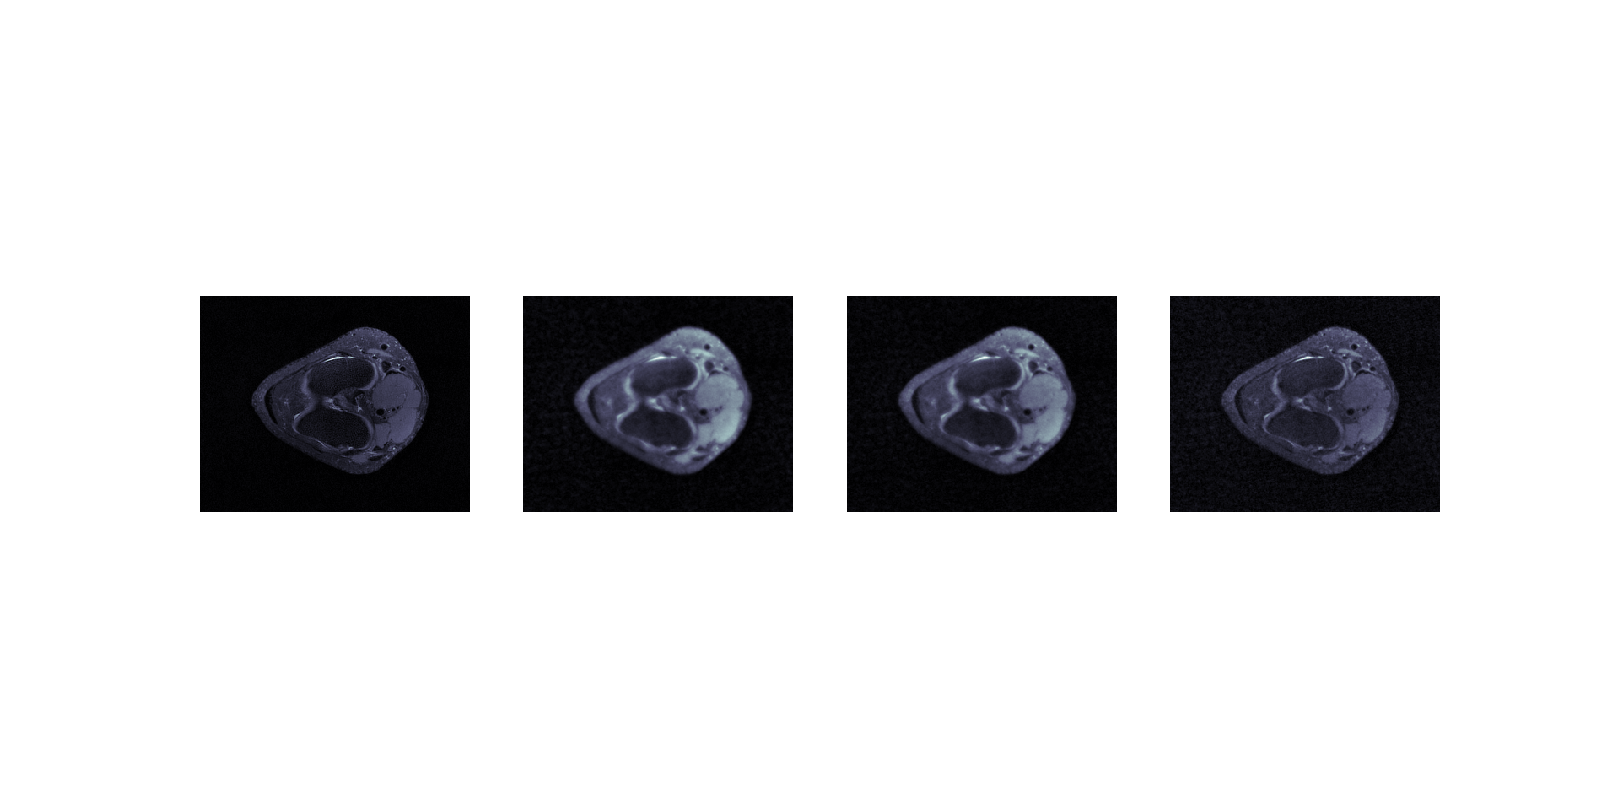

(-0.5, 319.5, 255.5, -0.5)

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(8,4), sharex=True, sharey=True)
ax[0].imshow(truth2[idx, slice_idx, ...]) #, vmax=vmax, vmin=0)
ax[0].axis('off')
ax[1].imshow(adj_recon2[idx, slice_idx, ...]) #, vmax=vmax, vmin=0)
ax[1].axis('off')
ax[2].imshow(cg_recon2[idx, slice_idx, ...]) #, vmax=vmax, vmin=0)
ax[2].axis('off')
ax[3].imshow(meld_recon2[idx, slice_idx, ...]) #, vmax=vmax, vmin=0)
ax[3].axis('off')

<IPython.core.display.Javascript object>


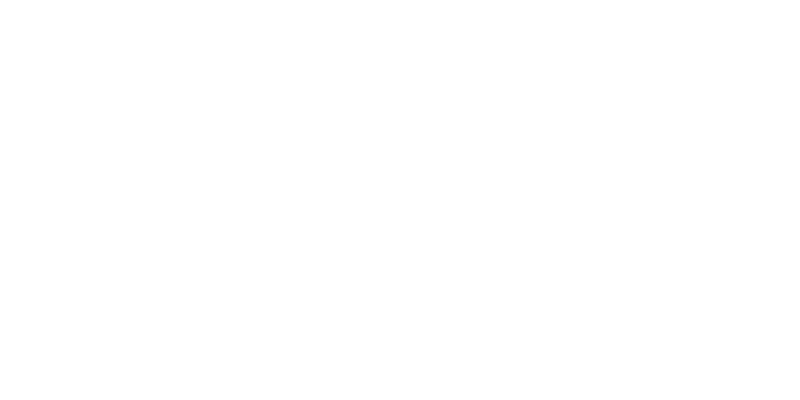

IndexError: index 120 is out of bounds for axis 1 with size 50

In [28]:
idx = 2
slice_idx = 35

slice_idx2 = 120
fig, ax = plt.subplots(1, 4, figsize=(8,4), sharex=True, sharey=True)
ax[0].imshow(view(truth2[idx, 1:, slice_idx2, ...]))
ax[0].axis('off')
ax[1].imshow(view(adj_recon2[idx, 1:, slice_idx2, ...]))
ax[1].axis('off')
ax[2].imshow(view(cg_recon2[idx, 1:, slice_idx2, ...]))
ax[2].axis('off')
ax[3].imshow(view(meld_recon2[idx, 1:, slice_idx2, ...]))
ax[3].axis('off')
plt.savefig('./figures/3d_xz_4unrolls_5layers_32ch.pdf', dpi=500, transparent=True)

# slice_idx2 = 100
# fig, ax = plt.subplots(1, 4, figsize=(8,4), sharex=True, sharey=True)
# ax[0].imshow(truth2[idx, 1:, :, slice_idx2])
# ax[0].axis('off')
# ax[1].imshow(adj_recon2[idx, 1:, :, slice_idx2])
# ax[1].axis('off')
# ax[2].imshow(cg_recon2[idx, 1:, :, slice_idx2])
# ax[2].axis('off')
# ax[3].imshow(meld_recon2[idx, 1:, :, slice_idx2])
# ax[3].axis('off')


## comparing CG quality

In [41]:
mri_network.mri_model.verbose = True
cg_0 = getAbs(mri_network.mri_model(torch.zeros_like(adj_0), max_iter = 5, eps=1e-12, device = device).detach().cpu()).numpy()
cg_1 = getAbs(mri_network.mri_model(torch.zeros_like(adj_0), max_iter = 8, eps=1e-12, device = device).detach().cpu()).numpy()
cg_2 = getAbs(mri_network.mri_model(torch.zeros_like(adj_0), max_iter = 10, eps=1e-12, device = device).detach().cpu()).numpy()


cg_0 = np.array(cg_0).reshape((Nbatch_size,50,256,320))
cg_1 = np.array(cg_1).reshape((Nbatch_size,50,256,320))
cg_2 = np.array(cg_2).reshape((Nbatch_size,50,256,320))

<IPython.core.display.Javascript object>


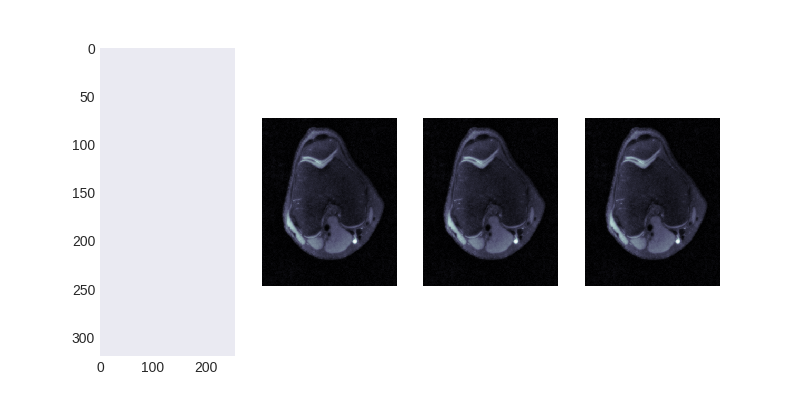

(-0.5, 255.5, 319.5, -0.5)

In [49]:
idx = 1
slice_idx = 35

fig, ax = plt.subplots(1, 4, figsize=(8,4), sharex=True, sharey=True)
# ax[0].imshow(view(truth2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
# ax[0].axis('off')
ax[1].imshow(view(cg_0[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[1].axis('off')
ax[2].imshow(view(cg_1[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[2].axis('off')
ax[3].imshow(view(cg_2[idx, slice_idx, ...])) #, vmax=vmax, vmin=0)
ax[3].axis('off')